In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()

read icdata


In [3]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
print(np.sum(icwidths))

1134450


In [ ]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.379113,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.386622,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.387892,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.392677,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.404776,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.961110,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.962666,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.963556,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.963972,2.98,0.21,332.199,44.720,31.489,134.811


In [24]:
column

['NAME', 'RAJD', 'DECJD', 'F0', 'DIST']

In [25]:
mspdata

,1,2,3,4
0,0.74238,62.26928,8.6682478274,6.357
1,1.52,18.5831,1.4414462816,0.86
2,1.7571,73.0521,3.165827392,1.4
3,2.9,8.17,0.391716,5.399
4,3.57396,47.77594,0.805997239145,1.776
...,...,...,...,...
3337,357.764,85.55573,0.98840874179,2.594
3338,358,65,0.859107,3.058
3339,358.60833,-22.86472,1.792128,1.108
3340,358.5199292,61.9296792,1.058443115007,2.439


In [44]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/atnfv1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()

for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content)#.drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()
#column.insert(0, "index")
mspdata.columns = column
line = []
lines = []

column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)
mspdata

,NAME,RAJD,DECJD,F0,DIST
0,J0002+6216,0.74238,62.26928,8.6682478274,6.357
1,J0006+1834,1.52,18.5831,1.4414462816,0.86
2,J0007+7303,1.7571,73.0521,3.165827392,1.4
3,J0011+08,2.9,8.17,0.391716,5.399
4,B0011+47,3.57396,47.77594,0.805997239145,1.776
...,...,...,...,...,...
3337,J2351+8533,357.764,85.55573,0.98840874179,2.594
3338,J2352+65,358,65,0.859107,3.058
3339,J2354-22,358.60833,-22.86472,1.792128,1.108
3340,B2351+61,358.5199292,61.9296792,1.058443115007,2.439


In [5]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])

In [86]:
psra = msra
psdec = msdec
psra2 = np.deg2rad([(i + 180)%360 - 180 for i in psra])
nura = np.deg2rad([(i + 180)%360 - 180 for i in icra])
nudec = np.deg2rad(icdec)
#[psra[0], psra2[0]]
psra = np.deg2rad(psra)
psdec = np.deg2rad(psdec)
p3 =[]
for i in psra2:
    if i < 0 and i > np.deg2rad(-110):
        p3.append(i)

radec = scr(ra = msra * u.degree, dec = msdec * u.degree, frame = 'icrs')           #CONVERSION
nudec = scr(ra = icra * u.degree, dec = icdec * u.degree, frame = 'icrs')           #CONVERSION
radec = radec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES
nudec = nudec.galactic      #CONVERSION FROM RA,DEC TO GALACTIC COORDINATES

gl = [(i + np.pi)%(2*np.pi) - np.pi for i in radec.l.radian]
gb = radec.b.radian

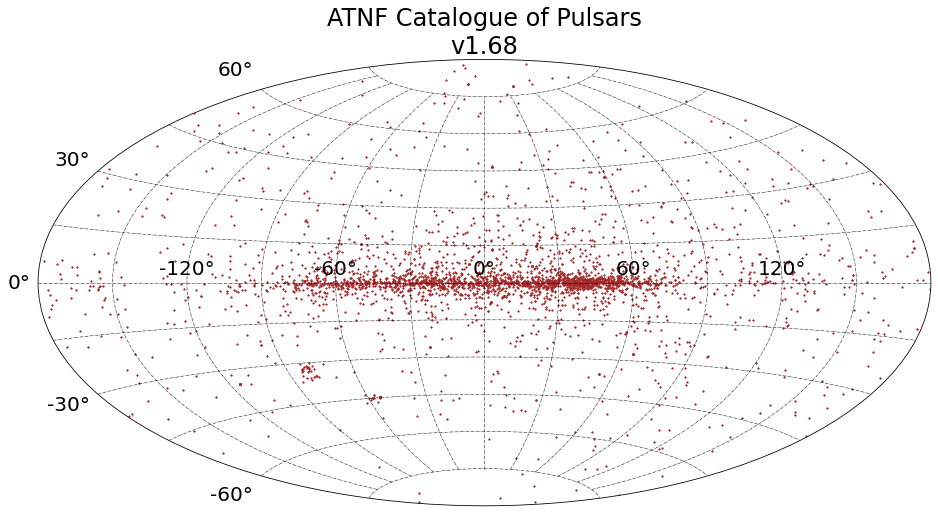

In [87]:
#Plotting atnf pulsars
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
#plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='aitoff')
plott = ax2.scatter(gl, gb,marker='*', c='brown',s = 2, label='Pulsars')
#plt.title("GALACTIC COORDINATES", fontdict=font)
#ax2.scatter(msra, msdec,marker='o',color='b', s = 1.2)
#ax2.scatter(icra, icdec, marker='.',color='green', alpha=0.05, s = 0.1)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
ax2.title.set_text("ATNF Catalogue of Pulsars\nv1.68") 
#ax2.title("ATNF catalog of Pulsars")

plt.savefig('/media/darkwake/VIB2/Project-IceCube/Project-Report/Images/pulsar-map.jpg')
plt.show()

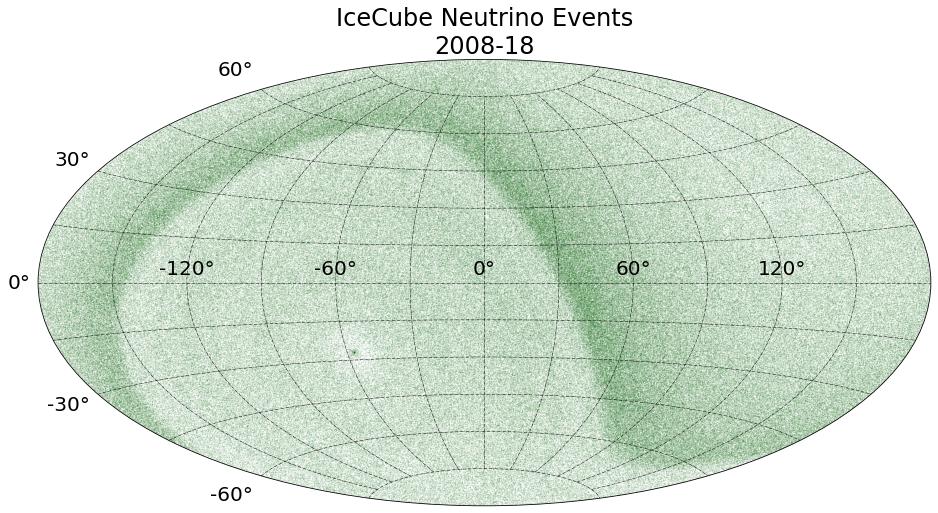

In [84]:
gl = [(i + np.pi)%(2*np.pi) - np.pi for i in nudec.l.radian]
gb = nudec.b.radian
comap = 'copper_r'
fig = plt.figure(figsize=(16, 10))
plt.rcParams.update({'font.size': 20})
ax2 = plt.subplot(projection='aitoff')
ax2.scatter(gl, gb, marker='.',color='green', alpha=0.1, s = 0.2)
ax2.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2,2, 5)))
ax2.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
ax2.yaxis.set_major_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-2, 2, 5)))
ax2.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
ax2.grid(True, which='both', color='black', lw=0.5, ls='-.')
ax2.title.set_text("IceCube Neutrino Events\n2008-18")

plt.savefig('/media/darkwake/VIB2/Project-IceCube/Project-Report/Images/nu-map.jpg')
